In [1]:
import cooler
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

resolution = 10000

c = cooler.Cooler('/Users/neda/prostate-samples/PCa13266.multi-res.cool::/resolutions/10000')
total_num_reads = sum(c.pixels()[:,].iloc[:,2])
bin_names = c.bins()[:,]




In [2]:
def interaction_spurious_prob(chr_name1, region1, chr_name2, region2):
    first_bin_num = bin_names[bin_names.chrom == chr_name1].iloc[int(region1/resolution)].name
    second_bin_num = bin_names[bin_names.chrom == chr_name2].iloc[int(region2/resolution)].name
    region1_reads = np.sum(c.matrix(balance = False)[first_bin_num,])
    region2_reads = np.sum(c.matrix(balance = False)[second_bin_num,])
    ri = region1_reads / (2*total_num_reads)
    rj = region2_reads / (2*total_num_reads)
    random_prob = 2 * ri * rj
    num_int = c.matrix(balance = False)[first_bin_num, second_bin_num]
    rp = 1 - scipy.stats.binom.cdf(num_int, total_num_reads, random_prob)
    return (rp)
    
# *** if a region doesn't have any interaction so random_prob = 0 and rp = 0 but it doesn't show signigficant interaction

In [3]:
chr3_TADs = pd.read_csv("/Users/neda/prostate-samples/PCa13266.50000bp.chr3.domains.tsv", sep = "\t")
chr3_TADs = chr3_TADs[chr3_TADs.tag == "domain"]
down_bound = chr3_TADs.loc[chr3_TADs['size'].idxmax(),'from.coord']
up_bound = chr3_TADs.loc[chr3_TADs['size'].idxmax(),'to.coord']
peaks = pd.read_csv("/Users/neda/prostate-samples/PCa13266-ChipSeq/Pca13266_summits.bed", header = None, sep = "\t"
                   , names = ['chr_name', 'lower_bound', "upper_bound", "name", "enrichment"])
f_peaks = peaks[(peaks.chr_name == "chr3") & (peaks.lower_bound > down_bound) & (peaks.upper_bound < up_bound)]

In [4]:
down_bound_bin_num = bin_names[bin_names.chrom == "chr3"].iloc[int(down_bound/resolution)].name
up_bound_bin_num = bin_names[bin_names.chrom == "chr3"].iloc[int(up_bound/resolution)].name

In [5]:
bins_coverage = []
for i in range(down_bound_bin_num, up_bound_bin_num+1):
    bins_coverage.append(np.sum(c.matrix(balance = False)[i,]))

In [6]:
domain_length = len(bins_coverage)
prob_mat = np.zeros([domain_length,domain_length])
for i in range(domain_length):
    first_bin_num = down_bound_bin_num + i
    first_bin_coverage = bins_coverage[i] / (2*total_num_reads)
    for j in range(i,domain_length):
        second_bin_num = down_bound_bin_num + j
        second_bin_coverage = bins_coverage[j] / (2*total_num_reads)
        random_prob = 2 * first_bin_coverage * second_bin_coverage
        num_int = c.matrix(balance = False)[first_bin_num,second_bin_num]
        rp = 1 - scipy.stats.binom.cdf(num_int, total_num_reads, random_prob)
        prob_mat[i,j] = rp


In [50]:
prob_mat[10,10:20]
plt.plot(bins_coverage)
plt.show()

array([1.11022302e-16, 1.11022302e-16, 9.86497073e-09, 1.75415238e-14,
       9.35518028e-06, 3.43395021e-03, 1.37883926e-08, 6.68719169e-09,
       4.47322312e-03, 4.27550052e-03])

In [52]:
def vec_of_dist(matrix, x):
    return([matrix[i,i+x] for i in range(matrix.shape[1]-x)])
rand_prob_per_dist = []
for i in range(domain_length):
    rand_prob_per_dist.append(np.mean(vec_of_dist(prob_mat,i)))

In [65]:
peaks_loc = f_peaks['lower_bound'].tolist()
peaks_index = [int((p-down_bound)/resolution) for p in peaks_loc]

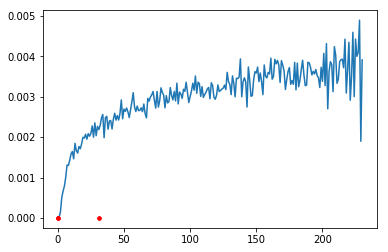

In [67]:
plt.plot(rand_prob_per_dist)
for i in range(len(peaks_index)):
    for j in range(i, len(peaks_index)):
        plt.plot(peaks_index[j]-peaks_index[i], prob_mat[peaks_index[i],peaks_index[j]], marker='o', markersize=3, color="red")
plt.show() 

In [68]:
for i in range(len(peaks_index)):
    for j in range(i, len(peaks_index)):
       print(prob_mat[peaks_index[i],peaks_index[j]])



1.1102230246251565e-16
1.1102230246251565e-16
1.0060538690237486e-05
1.0060538690237486e-05
1.1102230246251565e-16
1.0060538690237486e-05
1.0060538690237486e-05
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16
